# Household Behavior over the Life Cycle Exam 2024.
## Setup and Model Economy

The Bellman equation is for $t<T$
$$
\begin{align}
V_{t}(a_{t},k_{t}) & =\max_{c_{t},h_{t}}U(c_{t},h_{t})+\rho V_{t+1}(a_{t+1},k_{t+1})\\
 & \text{s.t.} \\
a_{t+1} & =(1+r)(a_{t}+(1-\tau)w_{t}h_{t}-c_{t})\\
k_{t+1} & =k_{t}+h_{t}\\
w_{t} & =w(1+\alpha k_{t})\\
c_{t} & >0\\
h_{t} & \geq0
\end{align}
$$
where preferences are 
$$
\begin{align}
U(c_{t},h_{t})=\frac{c_{t}^{1+\eta}}{1+\eta}-\beta\frac{h_{t}^{1+\gamma}}{1+\gamma}.
\end{align}
$$
There is no bequest motive in the baseline model such that for $t=T$,
$$
\begin{align}
V_{T}(a_{T},k_{T}) & =\max_{c_{T},h_{T}}U(c_{T},h_{T}).\\
 & \text{s.t.} \\
0 & \leq a_{T+1}=(1+r)(a_{T}+(1-\tau)w_{T}h_{T}-c_{T})
\end{align}
$$

The baseline parameters are $T=10$, $\rho=0.99$, $\beta=1.0$, $\eta=-2.5$,
$\gamma=2.5$, $\alpha=0.1$, $w=1.0$, $\tau=0.12$, and $r=0.03$.
When simulating, we draw initial level of wealth from a standard Normal
distribution, truncated at zero. Initial human capital is drawn from
a Normal distribution with mean zero and standard deviation $0.5$
and truncated at zero. We simulate $N=1000$ individuals for $T=10$
periods.

**Note:** I use $\tau=0.12$ rather than $0.1$ as that was a small typo in the model description. The orogonal code has this parametrization. If you have used the specified parametrization from the exam text, that is also fine. You results might differ a bit then.


## Setup

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

## Question 1
Since there is no bequest motive and utility is increasing in consumption, it will never be optimal to leave assets in the terminal period. Since $a^{\star}_{T+1}=0$, we can see from the constraint in the terminal problem that it must bind, $0=(1+r)(a_{T}+(1-\tau)w_{T}h_{T}-c_{T})$. Since $r>0$, this must mean that $0=a_{T}+(1-\tau)w_{T}h_{T}-c_{T}$. We can then re-arrange to isolate optimal consumption as a function of hours worked (to be chosen):
$$
c_{T}^{\star}(a_{T},k_{T}|h_{T})=a_{T}+(1-\tau)w_{T}h_{T}
$$

## Question 2
We will add human capital depreciation shocks in the model through, 
$$
k_{t+1}=\begin{cases}
\begin{array}{ll}
k_{t}+l_{t} & \text{with probability }1-p_{k}\\
(1-\delta)k_{t}+l_{t} & \text{with probability }p_{k}
\end{array}\end{cases}
$$
where $p_{k}=0.1$ is the probability that human capital will depreciate by 20% ($\delta=0.2$). 

To implement this in the model, the expected value must be calculated in equation (1) in the exam text. Concretely, we have that 
$$
V_{t}(a_{t},k_{t}) =\max_{c_{t},h_{t}}U(c_{t},h_{t})+\rho \mathbb{E}_t[V_{t+1}(a_{t+1},k_{t+1})]
$$
where
$$
\begin{align*}
\mathbb{E}_t[V_{t+1}(a_{t+1},k_{t+1})] &= p_{k}V_{t+1}(a_{t+1},(1-\delta)k_{t}+l_{t}) \\
    &+ (1-p_{k})V_{t+1}(a_{t+1},k_{t}+l_{t}).
\end{align*}
$$

To implement this, I have included ``par.prob_depre`` in the ``setup()`` function and updated the ``value_of_choice()`` function in the solution of the model. The depreciation rate is also included in the  ``setup()`` function as ``par.depre``.

I have also included a new uniform draw in the simulation of the model, stored in ``sim.draw_uniform`` and used in the ``simulate()`` function to determine the transition of the human capital.

In [2]:
# plot key output for model with and without human capital depreciation shock
from DynLaborModel_post import DynLaborModelClass

model_base = DynLaborModelClass(par={'prob_depre':0.0,'tau_a':0.0})
model = DynLaborModelClass(par={'prob_depre':0.6,'tau_a':0.0})

model_base.solve()
model_base.simulate()

model.solve()
model.simulate()

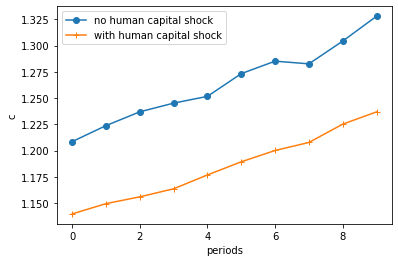

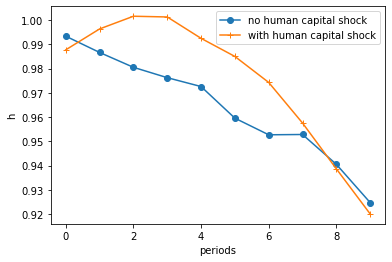

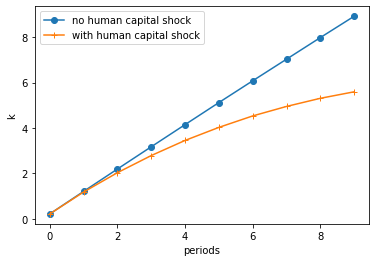

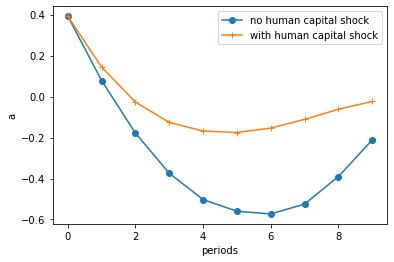

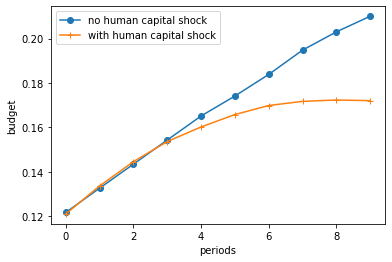

In [3]:
for val in ('c','h','k','a','budget'):
    base = np.mean(getattr(model_base.sim,val),axis=0)
    real = np.mean(getattr(model.sim,val),axis=0)
    fig,ax = plt.subplots()
    ax.plot(base,label='no human capital shock',marker='o')
    ax.plot(real,label='with human capital shock',marker='+')
    ax.set(ylabel=val,xlabel='periods')
    ax.legend()

## Question 3
To add a wealth tax, I modify the budget constraint, i.e. the transition equation for wealth is then
$$
a_{t+1}=(1+r)((1-\tau_{wealth}(a_t))a_{t}+(1-\tau)w_{t}h_{t}-c_{t})
$$
where
$$
\tau_{wealth}(a_t) = \tau_{a}\mathbf{1}(a_{t}>0).
$$
To implement this tax, I include in ``setup()`` the tax in ``par.tau_a`` and modify the wealth transition equation in the ``value_of_choice()`` function in the solution of the model and also update the transition in the ``simulate()`` function.

The wealth tax is also added to the government tax revenue and stored in ``sim.taxes``.

In [4]:
model_base = model.copy() # the model with human capital is now baseline

# new model with wealth tax
model.par.tau_a = 0.10
model.solve()
model.simulate()

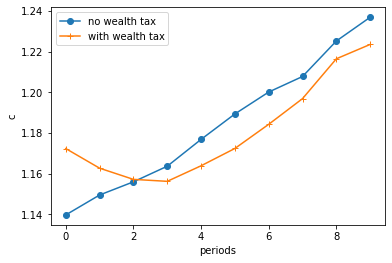

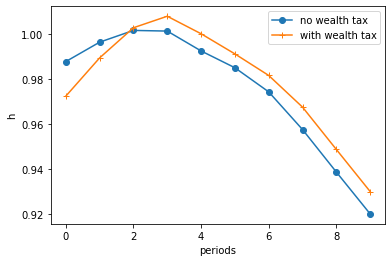

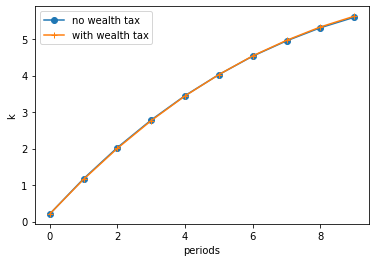

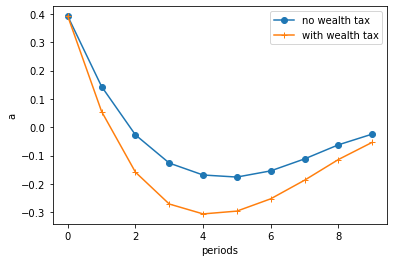

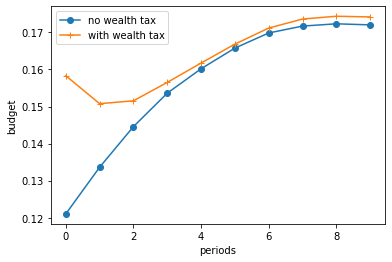

In [5]:
for val in ('c','h','k','a','budget'):
    base = np.mean(getattr(model_base.sim,val),axis=0)
    real = np.mean(getattr(model.sim,val),axis=0)
    fig,ax = plt.subplots()
    ax.plot(base,label='no wealth tax',marker='o')
    ax.plot(real,label='with wealth tax',marker='+')
    ax.set(ylabel=val,xlabel='periods')
    ax.legend()

## Question 4
A wealth tax affects optimal behavior through several channels. First, there is a direct substitution and effect: The return to wealth accumulation has reduced, leading to less incentive to save but also a need to save more to maintain desired consumption. Second, the substitution effect leads to a reduced incentive to work and the income effect leads to increased incentive to work. Since the wages are endogenous through human capital accumulation, there might be an incentive to reduce labor supply when young (if the wealth substitution effect dominates). 

## Question 5
The government surplus is just the sum of all taxes. Both from labor and wealth taxes.

The government budget is 1639.066
The welfare is -7.882


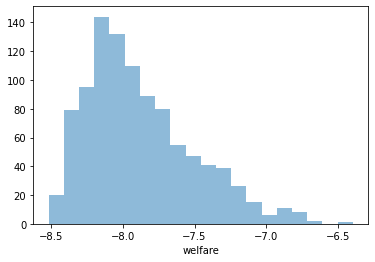

In [6]:
G_revenue = model.sim.budget.sum()
Welfare_indiv = np.sum(model.sim.util,axis=1)
Welfare = np.mean(Welfare_indiv)
print(f'The government budget is {G_revenue:2.3f}')
print(f'The welfare is {Welfare:2.3f}')

fig,ax = plt.subplots()
ax.hist(Welfare_indiv,alpha=0.5,bins=20);
ax.set(xlabel='welfare');

## Question 6
Perform the two tax reforms

In [7]:
model_ref1 = model.copy() # the model with wealth tax is now baseline
model_ref1.par.tau = 0.10

model_ref1.solve()
model_ref1.simulate()

model_ref2 = model.copy() 
model_ref2.par.tau_a = 0.05

model_ref2.solve()
model_ref2.simulate()

budget in baseline: 1639.07 (welfare -0.78821)
budget in reform 1: 1366.53 (welfare -0.77132)
budget in reform 2: 1608.68 (welfare -0.78604)


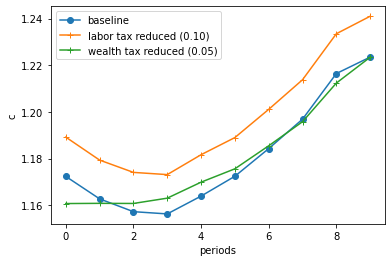

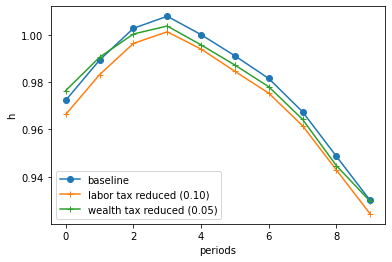

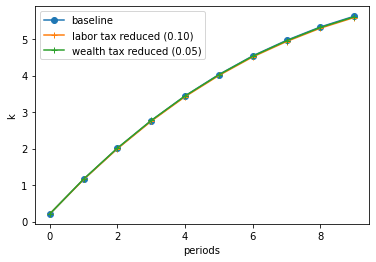

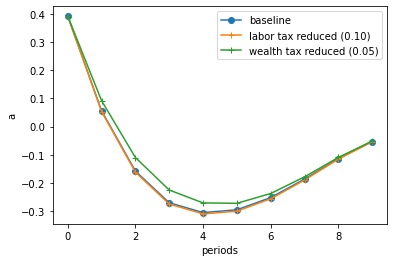

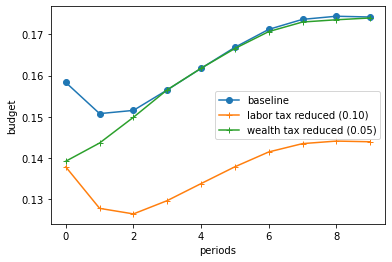

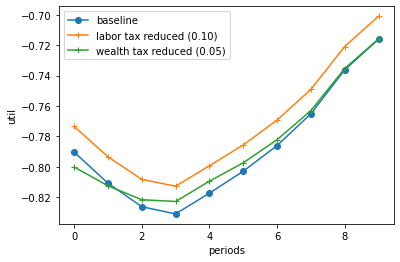

In [8]:
for val in ('c','h','k','a','budget','util'):
    base = np.mean(getattr(model.sim,val),axis=0)
    ref1 = np.mean(getattr(model_ref1.sim,val),axis=0)
    ref2 = np.mean(getattr(model_ref2.sim,val),axis=0)
    fig,ax = plt.subplots()
    ax.plot(base,label='baseline',marker='o')
    ax.plot(ref1,label=f'labor tax reduced ({model_ref1.par.tau:2.2f})',marker='+')
    ax.plot(ref2,label=f'wealth tax reduced ({model_ref2.par.tau_a:2.2f})',marker='+')
    ax.set(ylabel=val,xlabel='periods')
    ax.legend()

print(f'budget in baseline: {model.sim.budget.sum():2.2f} (welfare {model.sim.util.mean():2.5f})')
print(f'budget in reform 1: {model_ref1.sim.budget.sum():2.2f} (welfare {model_ref1.sim.util.mean():2.5f})')
print(f'budget in reform 2: {model_ref2.sim.budget.sum():2.2f} (welfare {model_ref2.sim.util.mean():2.5f})')

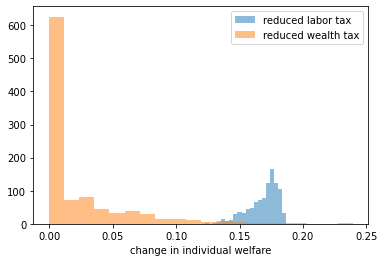

In [9]:
diff_ref1 = np.sum(model_ref1.sim.util,axis=1)-np.sum(model.sim.util,axis=1)
diff_ref2 = np.sum(model_ref2.sim.util,axis=1)-np.sum(model.sim.util,axis=1)
fig,ax = plt.subplots()
ax.hist(diff_ref1,alpha=0.5,bins=20);
ax.hist(diff_ref2,alpha=0.5,bins=20);
ax.legend(('reduced labor tax','reduced wealth tax'));
ax.set(xlabel='change in individual welfare');

## Question 7
We will here develop two alternative tax-systems that both generate the same amount of government budget of 1900


In [10]:
# general function that will return the distance to the goal of 2000
target = 1900
def gov_obj(val,name,model,target):
    # update the tax value
    setattr(model.par,name,val)

    # solve and simulate
    model.solve()
    model.simulate()

    # return the distance to the target
    print(f'{name} = {val:2.4f} => difference = {target - model.sim.budget.sum():2.4f}')
    return target - model.sim.budget.sum()

In [11]:
# find the labor tax for fixed wealth tax
from scipy.optimize import root_scalar

obj_func = lambda tax_val: gov_obj(tax_val,'tau',model.copy(),target)
opt = root_scalar(obj_func,bracket=[0.1,0.2],method='brentq',xtol=0.0001)

tau_G = opt.root
print(f'The labor tax that gives a budget of {target:2.0f} is {tau_G:2.4f} with tau_a = {model.par.tau_a:2.4f}')

tau = 0.1000 => difference = 533.4719
tau = 0.2000 => difference = -876.1973
tau = 0.1378 => difference = 14.8720
tau = 0.1389 => difference = 0.8612
tau = 0.1390 => difference = -2.2311
The labor tax that gives a budget of 1900 is 0.1389 with tau_a = 0.1000


In [12]:
# find the wealth tax for fixed labor tax
obj_func = lambda tax_val: gov_obj(tax_val,'tau_a',model.copy(),target)
opt = root_scalar(obj_func,bracket=[0.4,0.8],method='brentq',xtol=0.0001)

tau_a_G = opt.root
print(f'The optimal wealth tax that gives a budget of {target:2.0f} is {tau_a_G:2.4f} with tau = {model.par.tau:2.4f}')

tau_a = 0.4000 => difference = 144.4606
tau_a = 0.8000 => difference = -4.7501
tau_a = 0.7873 => difference = 0.9768
tau_a = 0.7894 => difference = -0.5295
tau_a = 0.7887 => difference = 0.3992
tau_a = 0.7890 => difference = 0.8420
tau_a = 0.7893 => difference = 0.7506
tau_a = 0.7894 => difference = 0.7832
The optimal wealth tax that gives a budget of 1900 is 0.7894 with tau = 0.1200


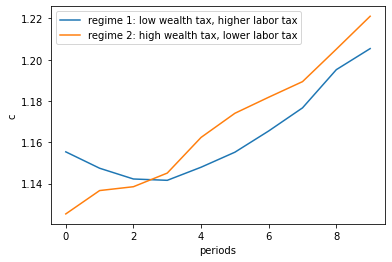

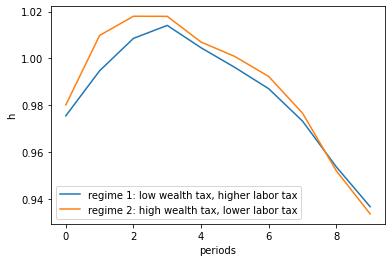

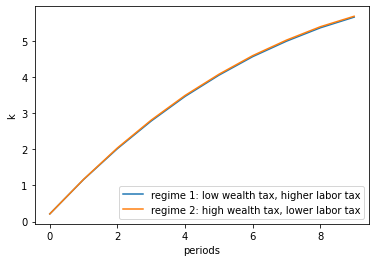

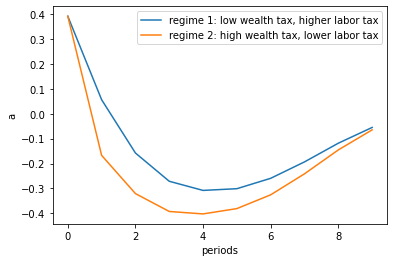

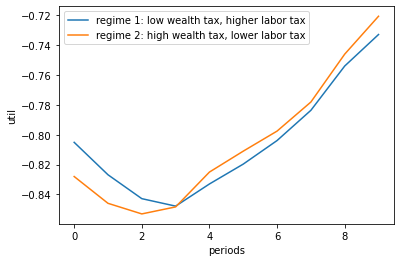

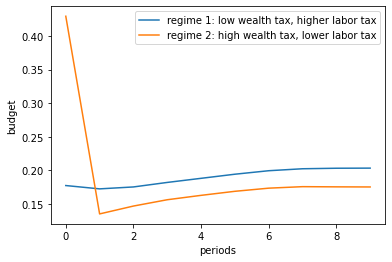

In [13]:
model1 = model.copy()
model1.par.tau = tau_G
model1.solve()
model1.simulate()

model2 = model.copy()
model2.par.tau_a = tau_a_G
model2.solve()
model2.simulate()

for val in ('c','h','k','a','util','budget'):
    var1 = np.nanmean(getattr(model1.sim,val),axis=0)
    var2 = np.nanmean(getattr(model2.sim,val),axis=0)
    fig,ax = plt.subplots()
    ax.plot(var1,label='regime 1: low wealth tax, higher labor tax')
    ax.plot(var2,label='regime 2: high wealth tax, lower labor tax')
    ax.set(ylabel=val,xlabel='periods')
    ax.legend();

## Question 8
compare the distribution of individual welfare across the two regimes and investigate the two groups who prefer one regime over the other

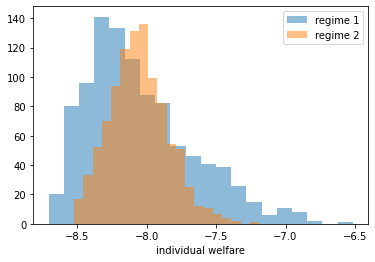

In [14]:
welfare1 = np.sum(model1.sim.util,axis=1)
welfare2 = np.sum(model2.sim.util,axis=1)
fig,ax = plt.subplots()
ax.hist(welfare1,alpha=0.5,bins=20);
ax.hist(welfare2,alpha=0.5,bins=20);
ax.legend(('regime 1','regime 2'));
ax.set(xlabel='individual welfare');

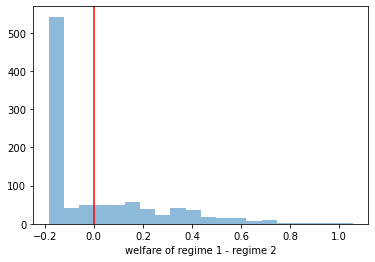

In [15]:
diff = welfare1-welfare2
fig,ax = plt.subplots()
ax.hist(diff,alpha=0.5,bins=20);
ax.set(xlabel='welfare of regime 1 - regime 2');
ax.axvline(x=0.0,color='red');

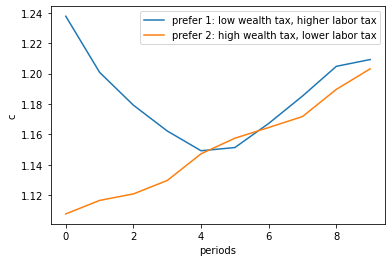

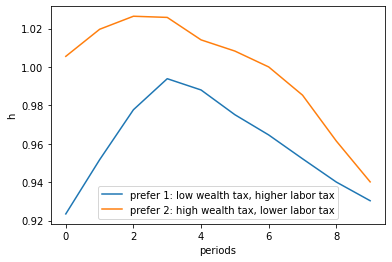

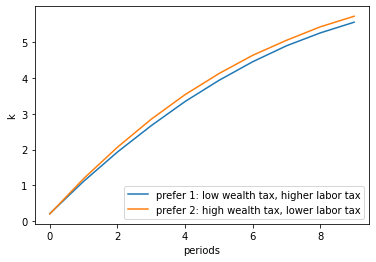

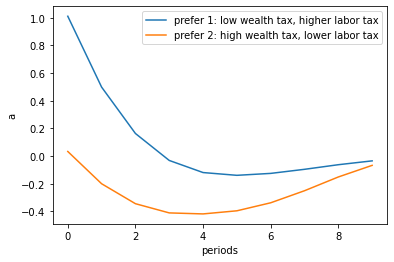

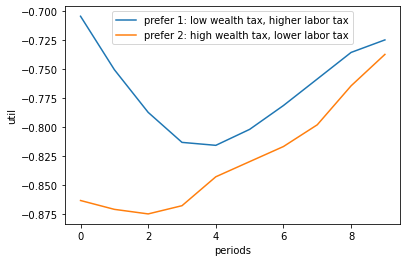

In [16]:
# look at the two groups
prefer1 = diff>0
nans1 = np.nan + np.ones(model.sim.util.shape)
nans1[prefer1,:] = 0.0
prefer2 = diff<=0
nans2 = np.nan + np.ones(model.sim.util.shape)
nans2[prefer2,:] = 0.0

model_plot = model1
for val in ('c','h','k','a','util'):
    var1 = np.nanmean(getattr(model_plot.sim,val)+nans1,axis=0)
    var2 = np.nanmean(getattr(model_plot.sim,val)+nans2,axis=0)
    fig,ax = plt.subplots()
    ax.plot(var1,label='prefer 1: low wealth tax, higher labor tax')
    ax.plot(var2,label='prefer 2: high wealth tax, lower labor tax')
    ax.set(ylabel=val,xlabel='periods')
    ax.legend();

# We see that the group that prefers regime 1 (low wealth tax and slightly higher labor tax) are those
# who have high levels of initial wealth and work less thus with lower human capital and ultimately wages.

## Question 9
We will now estimate the dis-utility from work, $\beta$, to match an average (over time and individuals) labor market supply of $35/37\approx0.95$.

Since the estimation setup is just-identified, the weighting matrix does not matter and we will minimize the squared distance between the data and the same moment calculated on simulated data from the model for a given guess of $\beta$.


In [17]:
# objective function
def obj_func(beta,model,mom_data,do_print=True):
    # update parameter
    model.par.beta = beta

    # solve and simulate model
    model.solve()
    model.simulate()

    # calculate moment on simulated data
    mom_sim = model.sim.h.mean()

    # return squared difference
    diff = (mom_data-mom_sim)
    obj = diff*diff
    if do_print: print(f'{beta:2.4f}->{obj:2.7f}')
    return obj

In [18]:
from scipy.optimize import minimize_scalar
mom_data = 35.0/37.0
res = minimize_scalar(obj_func,args=(model,mom_data),bounds=(0.8,1.5),method='bounded')
beta_est = model.par.beta
print(f'the estimated dis-utility from work is {beta_est:2.3f}')
# note: the model object now has the estimated value for the dis-utility.

1.0674->0.0003992
1.2326->0.0000510
1.3348->0.0004526
1.1966->0.0000007
1.1889->0.0000000
1.1911->0.0000012
1.1425->0.0000559
1.1711->0.0000043
1.1821->0.0000010
1.1899->0.0000006
1.1863->0.0000001
1.1877->0.0000005
1.1884->0.0000000
1.1887->0.0000000
1.1892->0.0000000
1.1887->0.0000000
1.1890->0.0000000
1.1888->0.0000000
1.1889->0.0000000
1.1890->0.0000000
1.1889->0.0000000
1.1889->0.0000000
1.1889->0.0000000
1.1889->0.0000000
1.1889->0.0000000
the estimated dis-utility from work is 1.189


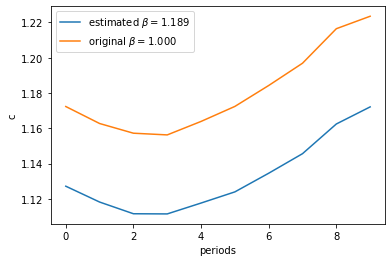

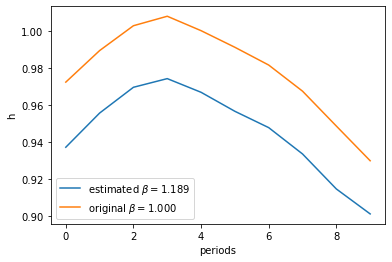

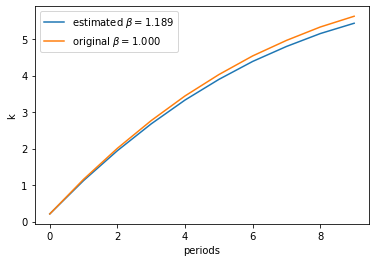

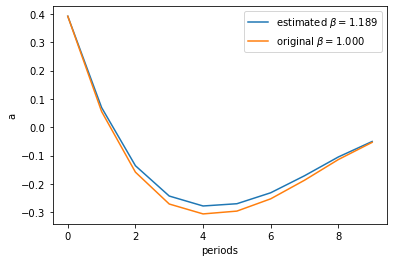

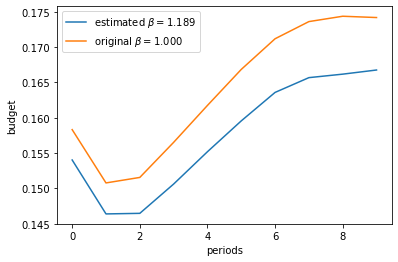

In [19]:
model_orig = model.copy()
model_orig.par.beta = 1.0
model_orig.solve()
model_orig.simulate()
for val in ('c','h','k','a','budget'):
    var1 = np.nanmean(getattr(model.sim,val),axis=0)
    var2 = np.nanmean(getattr(model_orig.sim,val),axis=0)
    fig,ax = plt.subplots()
    ax.plot(var1,label=f'estimated $\\beta={model.par.beta:2.3f}$')
    ax.plot(var2,label=f'original $\\beta={model_orig.par.beta:2.3f}$')
    ax.set(ylabel=val,xlabel='periods')
    ax.legend();

## Question 10

The new recursive formulation is
$$
\begin{align}
V_{t}(d_t,a_{t},k_{t}) & =\max_{c_{t},h_{t}}U(c_{t},h_{t})+\rho \mathbb{E}_t[V_{t+1}(d_{t+1},a_{t+1},k_{t+1})]\\
 & \text{s.t.} \\
a_{t+1} & =(1+r)((1-\tau_{wealth}(a_t))a_{t}+(1-\tau)w_{t}h_{t}-c_{t}+b\cdot d_t)\\
k_{t+1}&=\begin{cases}
\begin{array}{ll}
k_{t}+l_{t} & \text{with probability }1-p_{k}\\
(1-\delta)k_{t}+l_{t} & \text{with probability }p_{k}\\
\end{array}\end{cases} \\
w_{t} & =(1-\kappa\cdot d_t) w(1+\alpha k_{t})\\
d_{t+1} &= \begin{cases}
\begin{array}{ll}
1 & \text{with prob. }{P(d_{t+1}=1|d_{t})}\\
0 & \text{with prob. }{1-P(d_{t+1}=1|d_{t})} \\
\end{array}\end{cases} \\
c_{t} & >0\\
h_{t} & \geq0
\end{align}
$$
where the expected value is 
$$
\begin{align*}
\mathbb{E}_t[V_{t+1}(d_{t+1},a_{t+1},k_{t+1})] &= P(d_{t+1}=0|d_t)[p_{k}V_{t+1}(d_{t+1}=0,a_{t+1},(1-\delta)k_{t}+l_{t}) \\
    &+ (1-p_{k})V_{t+1}(d_{t+1}=0,a_{t+1},k_{t}+l_{t})] \\
    &+ P(d_{t+1}=1|d_t)[p_{k}V_{t+1}(d_{t+1}=1,a_{t+1},(1-\delta)k_{t}+l_{t}) \\
    &+ (1-p_{k})V_{t+1}(d_{t+1}=1,a_{t+1},k_{t}+l_{t})].
\end{align*}
$$

The government budget is now
$$
G(\tau,\tau_a,b) = \sum_i^N\sum_t^T \bigg[ \tau\cdot w_{i,t}h_{i,t} + \tau_a\cdot\max(a_{i,t},0) - b \cdot d_{i,t} \bigg].
$$

## Question 11
To implement the model, we need to modify both the solution and simulation module. 

In the solution, I add a loop over ``disabled`` taking values 0 and 1. The key function, that I update is the ``wage_func_before_tax()`` and the ``wealth_trans()`` functions since they now need to adjust wages if the new input ``disabled`` is 1.

In the simulation, I draw $N\cdot T$ uniform draws which I use to determine each period, if the individual is disabled in the next period. Finally, I subtract ``disability_benefits`` when calculating the government budget. 

In [20]:
model_final = DynLaborModelClass(par={'beta':beta_est,'num_d':2})
model_final.solve()
model_final.simulate()

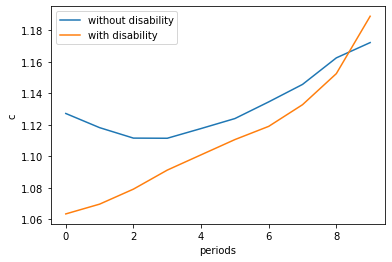

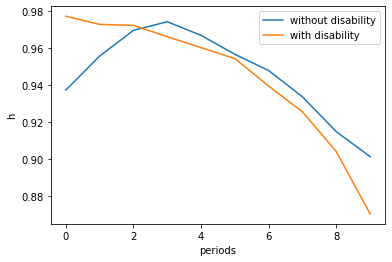

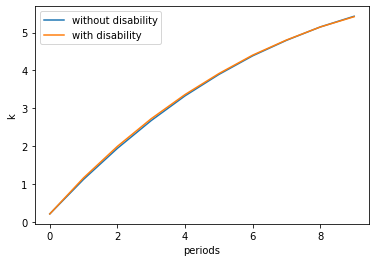

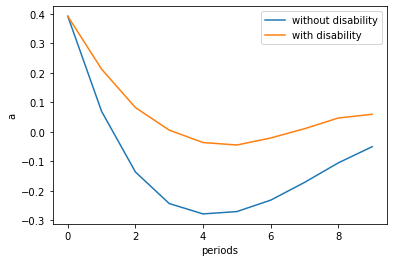

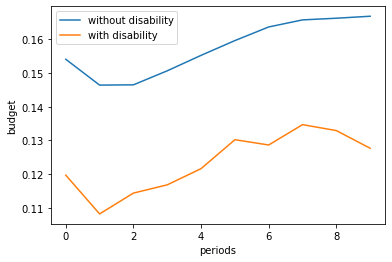

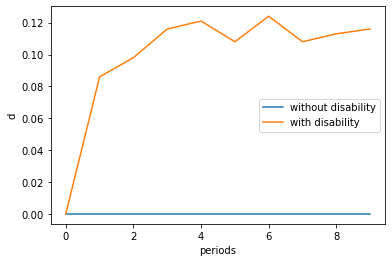

In [21]:
for val in ('c','h','k','a','budget','d'):
    var1 = np.nanmean(getattr(model.sim,val),axis=0)
    var2 = np.nanmean(getattr(model_final.sim,val),axis=0)
    fig,ax = plt.subplots()
    ax.plot(var1,label=f'without disability')
    ax.plot(var2,label=f'with disability')
    ax.set(ylabel=val,xlabel='periods')
    ax.legend();

## Question 12
We could find the level of disability benefits, $b^{\star}$, that would exactly balance the budget, such that $G=0$, by searching over values of $b$ that e.g. minimizes 
$$
b^{\star}=\arg\min_b G(b)^2.
$$

In our setting, we could also implement another iterative scheme, using that to set $G=0$, we have for iteration $j$,
$$
b^{j} = \frac{\sum_i^N\sum_t^T\tau w_{i,t}(b^{j-1})h_{i,t}(b^{j-1}) + \tau_a\max(a_{i,t}(b^{j-1}),0)}{\sum_i^N\sum_t^T d_{i,t}}.
$$
We could then iterate on $b$ until it does not change anymore.

If a government wants to keep a balanced budget, $G=0$, while reducing taxes, they will likely have to also reduce benefits, $b$. Such a combined policy would likely lead to increased labor supply (if substitution effect is dominating the income effect) and increased savings (in order to buffer against the lower level of benefits).